In [1]:
import pickle as pkl
from denoisers.ConditionalUnetDenoiser import ConditionalUnetDenoiser
from dataset.dataset import SaladsDataset
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from ddpm.ddpm_multinomial import Diffusion
import torch
import random
from utils import calculate_metrics
from Config import Config

In [2]:
# with open("../runs/unet_cond_ce/epoch_19900_batch_0_test.pkl", "rb") as f:
#     salads_final = pkl.load(f)
# 
# with open("../runs/unet_cond_ce_gtea/epoch_5900_batch_0_test.pkl", "rb") as f:
#     gtea_final = pkl.load(f)
# 
# with open("../runs/unet_cond_ce_breakfast/epoch_5800_train.pkl", "rb") as f:
#     breakfast_final_train = pkl.load(f)

In [3]:
def convert_dataset_to_df(dataset: SaladsDataset, activity_names: dict):
    deterministic, stochastic = torch.stack([x[0] for x in dataset], axis=0), torch.stack([x[1] for x in dataset], axis=0)
    deterministic = torch.argmax(deterministic.permute(0, 2, 1), dim=1)
    stochastic = stochastic.permute(0, 2, 1)
    
    df_deterministic = pd.DataFrame(
        {
            'concept:name': [activity_names[i.item()] for trace in deterministic for i in trace],
            'case:concept:name': [str(i) for i, trace in enumerate(deterministic) for _ in range(len(trace))]
        }
    )
    
    stochastic_list = [x.unsqueeze(0) for x in stochastic]
    
    return df_deterministic, stochastic_list

In [4]:
from sktr.sktr import run_sktr, prepare_df_cols_for_discovery
import json

def evaluate_models(data_path: str, denoiser_path: str, cfg_path: str, activity_names: dict):
    with open(data_path, "rb") as f:
        data = pkl.load(f)

    with open(cfg_path, "r") as f:
        cfg_json = json.load(f)
        cfg = Config(**cfg_json)

    dataset = SaladsDataset(data['target'], data['stochastic'])
    denoiser = ConditionalUnetDenoiser(in_ch=cfg.num_classes, out_ch=cfg.num_classes,
                                       max_input_dim=dataset.sequence_length).to('cuda').float()
    denoiser.load_state_dict(torch.load(denoiser_path)['model_state'])
    diffuser = Diffusion(noise_steps=cfg.num_timesteps)
    train, test = train_test_split(dataset, train_size=cfg.train_percent, shuffle=True, random_state=cfg.seed)
    gt = [torch.argmax(x[0], dim=1) for x in test]
    (df_train, _), (_, stochastic_test) = convert_dataset_to_df(train, activity_names), convert_dataset_to_df(test, activity_names)
    argmax_recovered = [torch.argmax(x[1], dim=1) for x in test]
    argmax_metrics = calculate_metrics(gt, argmax_recovered)
    print('calculated argmax')
    diffusion_recovered = [torch.argmax(diffuser.sample(denoiser, 1, cfg.num_classes, denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(), cfg.predict_on), dim=1) for x in test]
    diffusion_metrics = calculate_metrics(gt, [x[0].to('cpu') for x in diffusion_recovered])
    print('calculated diffusion')
    sktr_recovered = run_sktr(prepare_df_cols_for_discovery(df_train), stochastic_test, activity_names)
    sktr_metrics = calculate_metrics(gt, sktr_recovered)
    return argmax_metrics, diffusion_metrics, sktr_metrics

names_dict = {
    0: 'cut_tomato',
    1: 'place_tomato_into_bowl',
    2: 'cut_cheese',
    3: 'place_cheese_into_bowl',
    4: 'cut_lettuce',
    5: 'place_lettuce_into_bowl',
    6: 'add_salt',
    7: 'add_vinegar',
    8: 'add_oil',
    9: 'add_pepper',
    10: 'mix_dressing',
    11: 'peel_cucumber',
    12: 'cut_cucumber',
    13: 'place_cucumber_into_bowl',
    14: 'add_dressing',
    15: 'mix_ingredients',
    16: 'serve_salad_onto_plate',
    17: 'action_start',
    18: 'action_end',
    19: 'EOT'
}

# argmax_metrics, diffusion_metrics, sktr_metrics = evaluate_models("../data/pickles/50_salads_unified.pkl", "../runs/unet_cond_ce_salads_42_50/best.ckpt", "../runs/unet_cond_ce_salads_42_50/cfg.json", names_dict)

In [5]:
with open("../data/pickles/50_salads_500_sample.pkl", "rb") as f:
    salads_data = pkl.load(f)

with open("../data/pickles/gtea_500_sample.pkl", "rb") as f:
    gtea_data = pkl.load(f)

# with open("../data/pickles/breakfast_unified.pkl", "rb") as f:
#     breakfast_data = pkl.load(f)

In [6]:
diffuser = Diffusion(noise_steps=500)

In [7]:
salads_dataset = SaladsDataset(salads_data['target'], salads_data['stochastic'])
gtea_dataset = SaladsDataset(gtea_data['target'], gtea_data['stochastic'])
# breakfast_dataset = SaladsDataset(breakfast_data['target'], breakfast_data['stochastic'])

In [8]:
salads_train, salads_test = train_test_split(salads_dataset, train_size=0.5, shuffle=True, random_state=42)
gtea_train, gtea_test = train_test_split(gtea_dataset, train_size=0.5, shuffle=True, random_state=42)

In [18]:
import json

with open("../runs/50_salads_500_sample/cfg.json", "r") as f:
    cfg_json = json.load(f)
    salads_cfg = Config(**cfg_json)

with open("../runs/gtea_500_sample/cfg.json", "r") as f:
    cfg_json = json.load(f)
    gtea_cfg = Config(**cfg_json)
    
gtea_cfg.activity_names = {
    0: "a_0",
    1: "a_1",
    2: "a_2",
    3: "a_3",
    4: "a_4",
    5: "a_5",
    6: "a_6",
    7: "a_7",
    8: "a_8",
    9: "a_9",
    10: "a_10",
    11: "EOT"
}

In [10]:
from utils import train_sktr
from utils import discover_dk_process

salads_net, salads_init_marking, salads_final_marking = discover_dk_process(salads_train, salads_cfg)
salads_net

places: [ p_10, p_11, p_12, p_13, p_16, p_17, p_18, p_19, p_20, p_21, p_22, p_23, p_24, p_25, p_27, p_28, p_29, p_30, p_31, p_33, p_34, p_35, p_36, p_38, p_39, p_40, p_41, p_43, p_44, p_45, p_46, p_47, p_48, p_49, p_51, p_52, p_53, p_54, p_55, p_57, p_58, p_6, p_60, p_61, p_63, p_64, p_66, p_67, p_7, p_72, p_73, p_75, p_76, sink, source ]
transitions: [ (0cae0990-97eb-4dfc-b8cc-32c33bcf5c37, 'cut_lettuce'), (0cb12063-88d5-46e8-bc3d-0bf001623a94, 'add_salt'), (43bef094-7e82-475a-87d1-01cf4335761d, 'cut_cucumber'), (4a9d3753-e833-4517-a2e0-86ca1a0cdf0e, 'cut_cheese'), (4dc8647b-68e0-4c0a-9131-a500a0e617f9, 'add_oil'), (573976e3-4f02-4b91-bd0a-7f125bd7dea0, 'add_vinegar'), (57f1a98f-6e42-4ab5-b514-67217d4d46a7, 'mix_ingredients'), (5cda289a-0992-4d87-be4c-39314547076d, 'place_cucumber_into_bowl'), (62c12130-77fc-4714-a73d-39aa29663bfc, 'peel_cucumber'), (64a96176-751b-432b-b12e-967ec085da12, 'cut_tomato'), (724e9932-9446-4c1c-b7b1-cc62c7569fed, 'add_pepper'), (8867bdfb-6303-4c83-af39-fe5d

In [12]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

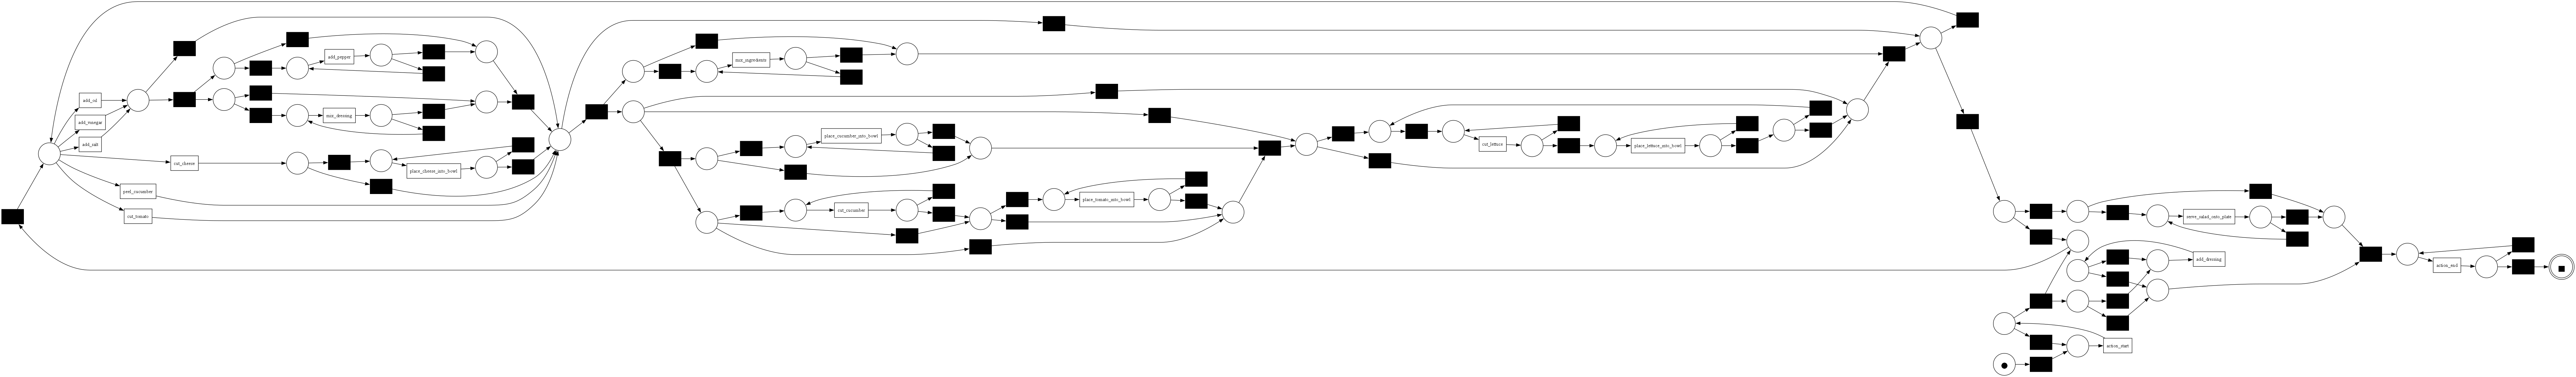

In [13]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(salads_net, salads_init_marking, salads_final_marking)
pn_visualizer.view(gviz)

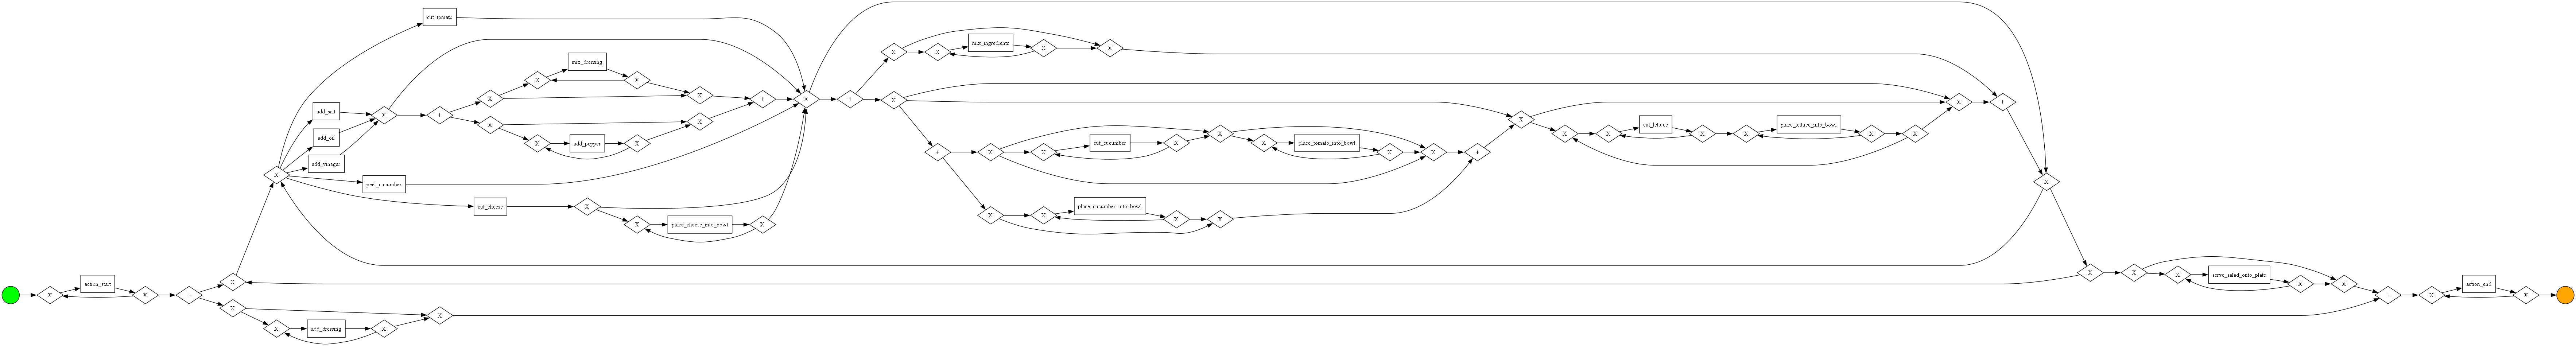

In [14]:
from pm4py import convert_to_bpmn, view_bpmn

salads_bpmn = convert_to_bpmn(salads_net, salads_init_marking, salads_final_marking)
view_bpmn(salads_bpmn)

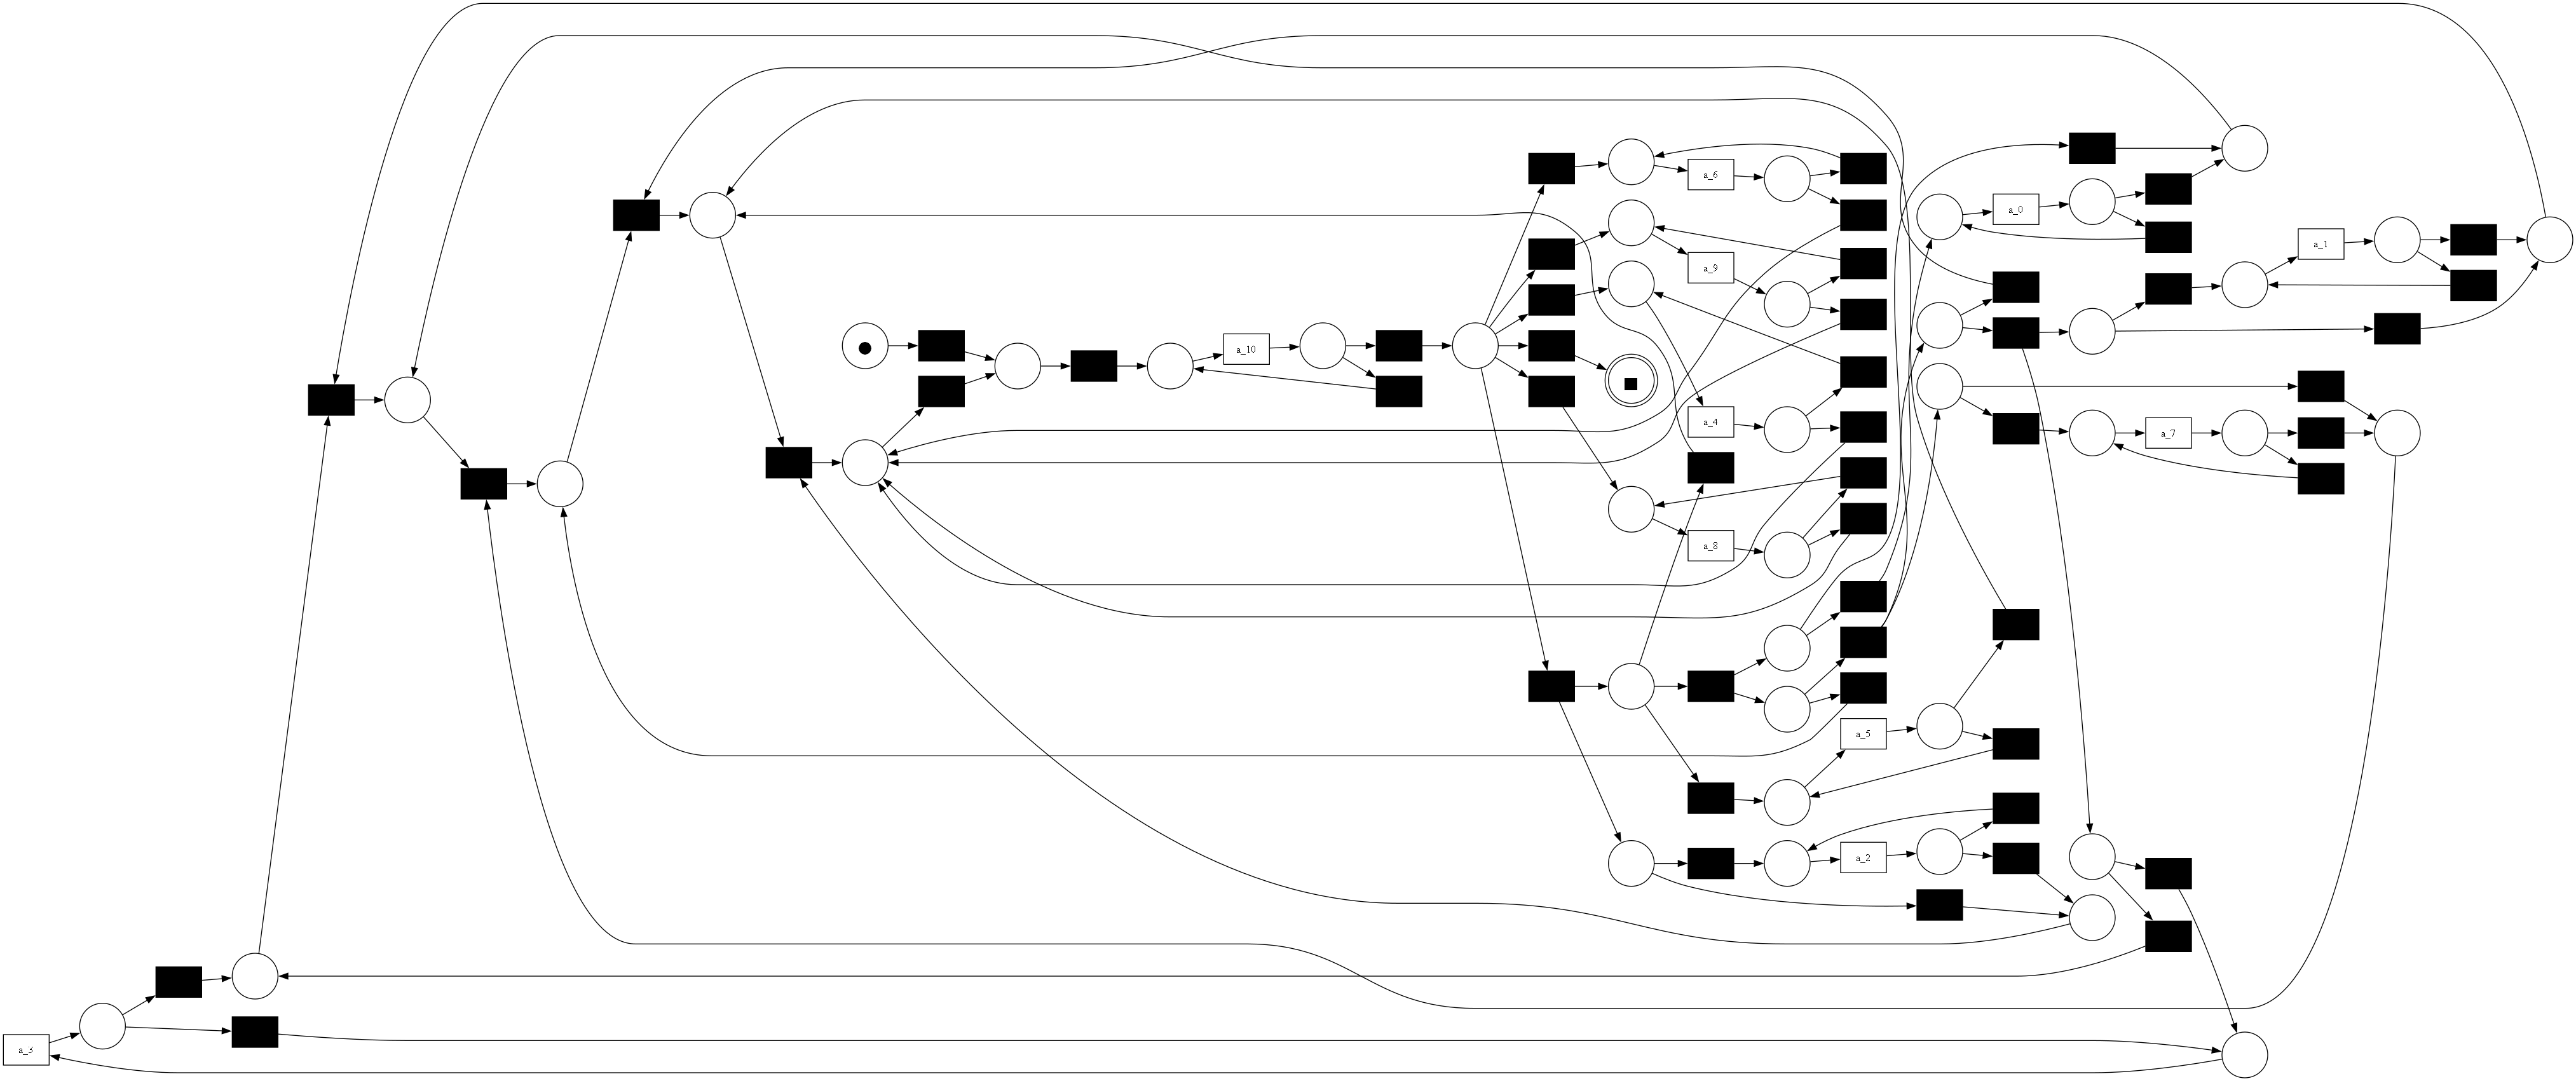

In [21]:
gtea_net, gtea_init_marking, gtea_final_marking = discover_dk_process(gtea_train, gtea_cfg)
gviz = pn_visualizer.apply(gtea_net, gtea_init_marking, gtea_final_marking)
pn_visualizer.view(gviz)

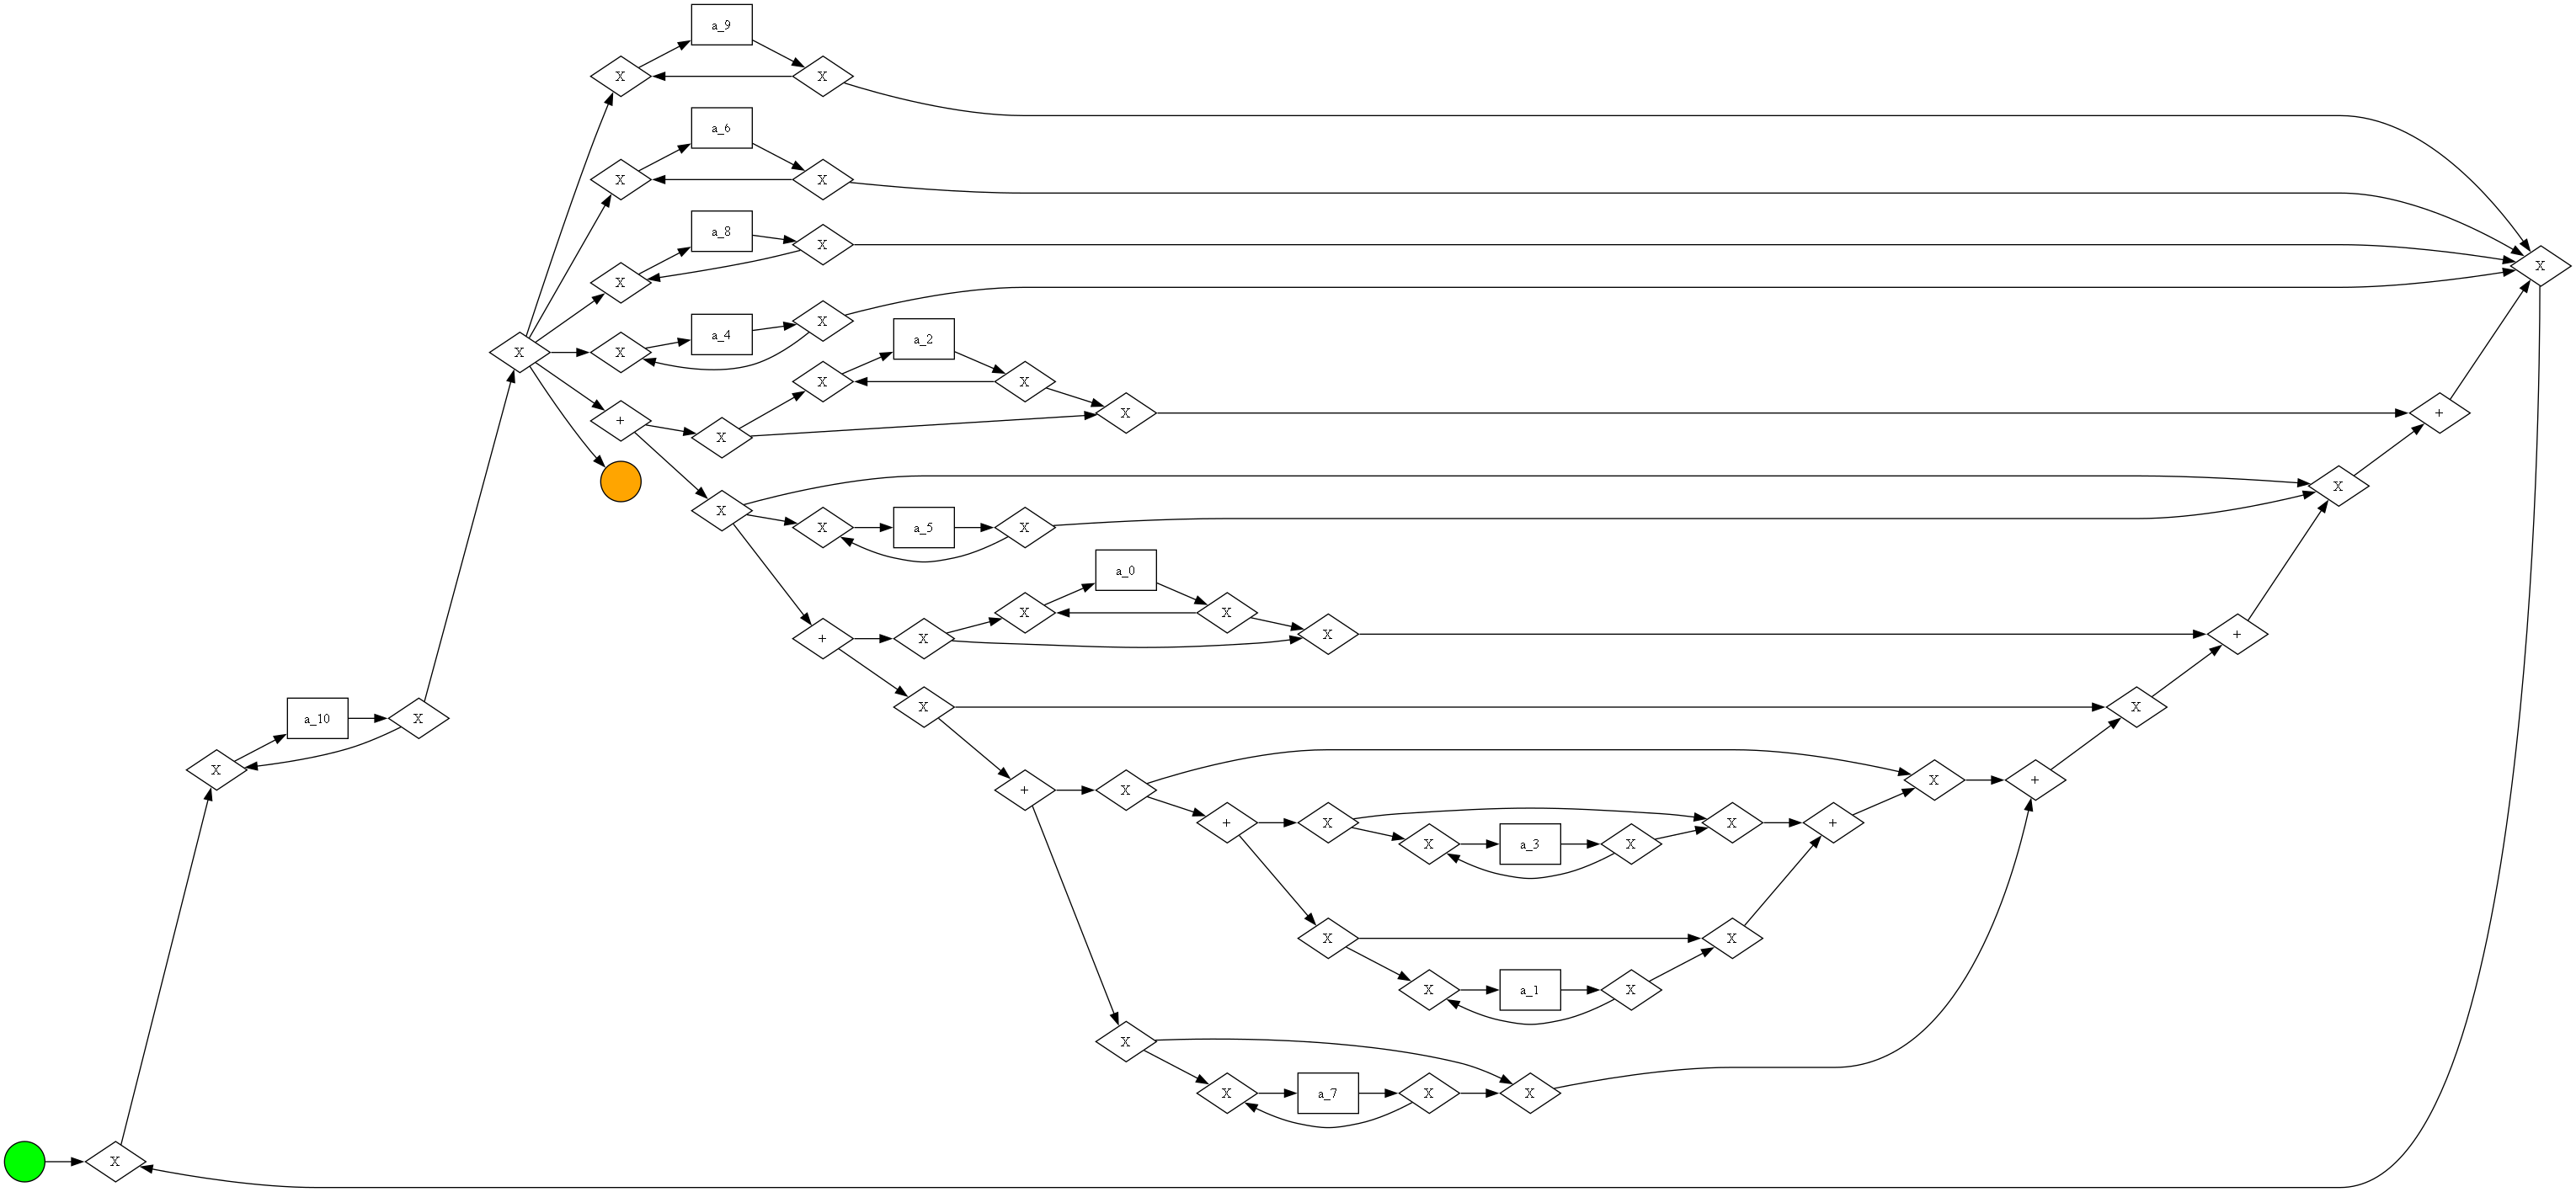

In [22]:
gtea_bpmn = convert_to_bpmn(gtea_net, gtea_init_marking, gtea_final_marking)
view_bpmn(gtea_bpmn)

In [23]:
salads_denoiser = ConditionalUnetDenoiser(in_ch=20, out_ch=20, max_input_dim=salads_dataset.sequence_length).to(
    'cuda').float()
gtea_denoiser = ConditionalUnetDenoiser(in_ch=12, out_ch=12, max_input_dim=gtea_dataset.sequence_length).to(
    'cuda').float()
# breakfast_denoiser = ConditionalUnetDenoiser(in_ch=49, out_ch=49, max_input_dim=breakfast_dataset.sequence_length).to(
#     'cuda').float()

In [24]:
salads_denoiser.load_state_dict(torch.load("../runs/50_salads_500_sample/best.ckpt")['model_state'])

<All keys matched successfully>

In [25]:
gtea_denoiser.load_state_dict(torch.load("../runs/gtea_500_sample/best.ckpt")['model_state'])

<All keys matched successfully>

In [43]:
# breakfast_denoiser.load_state_dict(torch.load("../runs/unet_cond_ce_breakfast_42_50/best.ckpt")['model_state'])

In [26]:
salads_gt = [torch.argmax(x[0], dim=1) for x in salads_test]
gtea_gt = [torch.argmax(x[0], dim=1) for x in gtea_test]

In [27]:
salads_argmax_recovered = [torch.argmax(x[1], dim=1) for x in salads_test]
salads_argmax_metrics = calculate_metrics(salads_gt, salads_argmax_recovered)

In [28]:
gtea_argmax_recovered = [torch.argmax(x[1], dim=1) for x in gtea_test]
gtea_argmax_metrics = calculate_metrics(gtea_gt, gtea_argmax_recovered)

In [29]:
salads_diffusion_recovered = [torch.argmax(diffuser.sample(salads_denoiser, 1, salads_cfg.num_classes, salads_denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(), salads_cfg.predict_on), dim=1) for x in salads_test]
salads_diffusion_metrics = calculate_metrics(salads_gt, [x[0].to('cpu') for x in salads_diffusion_recovered])

In [30]:
gtea_diffusion_recovered = [torch.argmax(diffuser.sample(gtea_denoiser, 1, gtea_cfg.num_classes, gtea_denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(), gtea_cfg.predict_on), dim=1) for x in gtea_test]
gtea_diffusion_metrics = calculate_metrics(gtea_gt, [x[0].to('cpu') for x in gtea_diffusion_recovered])

In [55]:
with open("../runs/sktr_50_salads/recovered_traces.pkl", "rb") as f:
    salads_sktr_recovered = pkl.load(f)

with open("../runs/sktr_gtea/recovered_traces.pkl", "rb") as f:
    gtea_sktr_recovered = pkl.load(f)

In [56]:
gtea_sktr_recovered = [x for x in gtea_sktr_recovered]

In [57]:
salads_sktr_metrics = calculate_metrics(salads_gt, salads_sktr_recovered)
gtea_sktr_metrics = calculate_metrics(gtea_gt, gtea_sktr_recovered)

In [58]:
salads_argmax_metrics

(0.7957661290322582, 0.787002864284011, 0.7915065159595964, 0.75613787281295)

In [59]:
salads_diffusion_metrics

(0.8828629032258066,
 0.8309719947022295,
 0.8215070802052695,
 0.8104996036365095)

In [60]:
salads_sktr_metrics

(0.6670362903225808,
 0.6504110026275975,
 0.6501370546424637,
 0.6057036475986635)

In [61]:
gtea_argmax_metrics

(0.7973790322580644, 0.7846014949947744, 0.8022992757289062, 0.777067203528203)

In [62]:
gtea_diffusion_metrics

(0.8657834101382488, 0.839598409110831, 0.8710456592154473, 0.8453533194470013)

In [63]:
gtea_sktr_metrics

(0.49351958525345624,
 0.4619427267908543,
 0.44920289581700434,
 0.4096355558206243)

In [9]:
salads_original = torch.argmax(torch.softmax(salads_final['original'], dim=1), dim=1)
salads_recovered = torch.argmax(torch.softmax(salads_final['denoised'], dim=1), dim=1)
gtea_original = torch.argmax(torch.softmax(gtea_final['original'], dim=1), dim=1)
gtea_recovered = torch.argmax(torch.softmax(gtea_final['denoised'], dim=1), dim=1)
breakfast_original = torch.argmax(torch.softmax(breakfast_final_train['original'], dim=1), dim=1)
breakfast_recovered = torch.argmax(torch.softmax(breakfast_final_train['denoised'], dim=1), dim=1)

In [49]:
train_salads, test_salads = train_test_split(salads_dataset, train_size=0.5, shuffle=True, random_state=42)
train_gtea, test_gtea = train_test_split(gtea_dataset, train_size=0.5, shuffle=True, random_state=42)
train_breakfast, test_breakfast = train_test_split(breakfast_dataset, train_size=0.5, shuffle=True, random_state=42)

In [65]:
calculate_metrics([torch.argmax(x[0], dim=1) for x in test_salads], [torch.argmax(x[1], dim=1) for x in test_salads])

(0.8179981773997568,
 0.8006439456548552,
 0.8015677034026497,
 0.7758749201725211)

In [80]:
fuckyourmom = [torch.argmax(diffuser.sample(salads_denoiser, 1, 20, salads_denoiser.max_input_dim, x[1].permute(1, 0).unsqueeze(0).to('cuda').float(),
                              'original'), dim=1) for x in test_salads]

In [8]:
labeled, stochastic = salads_dataset[:]

In [21]:
labeled2 = torch.argmax(labeled.permute(0, 2, 1), dim=1)

In [27]:
names_dict = {
    0: 'cut_tomato',
    1: 'place_tomato_into_bowl',
    2: 'cut_cheese',
    3: 'place_cheese_into_bowl',
    4: 'cut_lettuce',
    5: 'place_lettuce_into_bowl',
    6: 'add_salt',
    7: 'add_vinegar',
    8: 'add_oil',
    9: 'add_pepper',
    10: 'mix_dressing',
    11: 'peel_cucumber',
    12: 'cut_cucumber',
    13: 'place_cucumber_into_bowl',
    14: 'add_dressing',
    15: 'mix_ingredients',
    16: 'serve_salad_onto_plate',
    17: 'action_start',
    18: 'action_end',
    19: 'EOT'
}

In [29]:
len([names_dict[i.item()] for trace in labeled2 for i in trace])

263360

In [32]:
len([i for i, trace in enumerate(labeled2) for j in range(len(trace))])

263360

In [38]:
temp2 = [x.unsqueeze(0) for x in stochastic.permute(0, 2, 1)]

In [87]:
calculate_metrics([torch.argmax(x[0], dim=1) for x in test_salads],
                  [f[0].to('cpu') for f in fuckyourmom])

(0.8732685297691372, 0.8493922957581013, 0.844677588378205, 0.827883289226255)

In [30]:
salads_argmax = torch.argmax(salads_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)
gtea_argmax = torch.argmax(gtea_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)
breakfast_argmax = torch.argmax(breakfast_dataset._SaladsDataset__data.permute(0, 2, 1), dim=1)

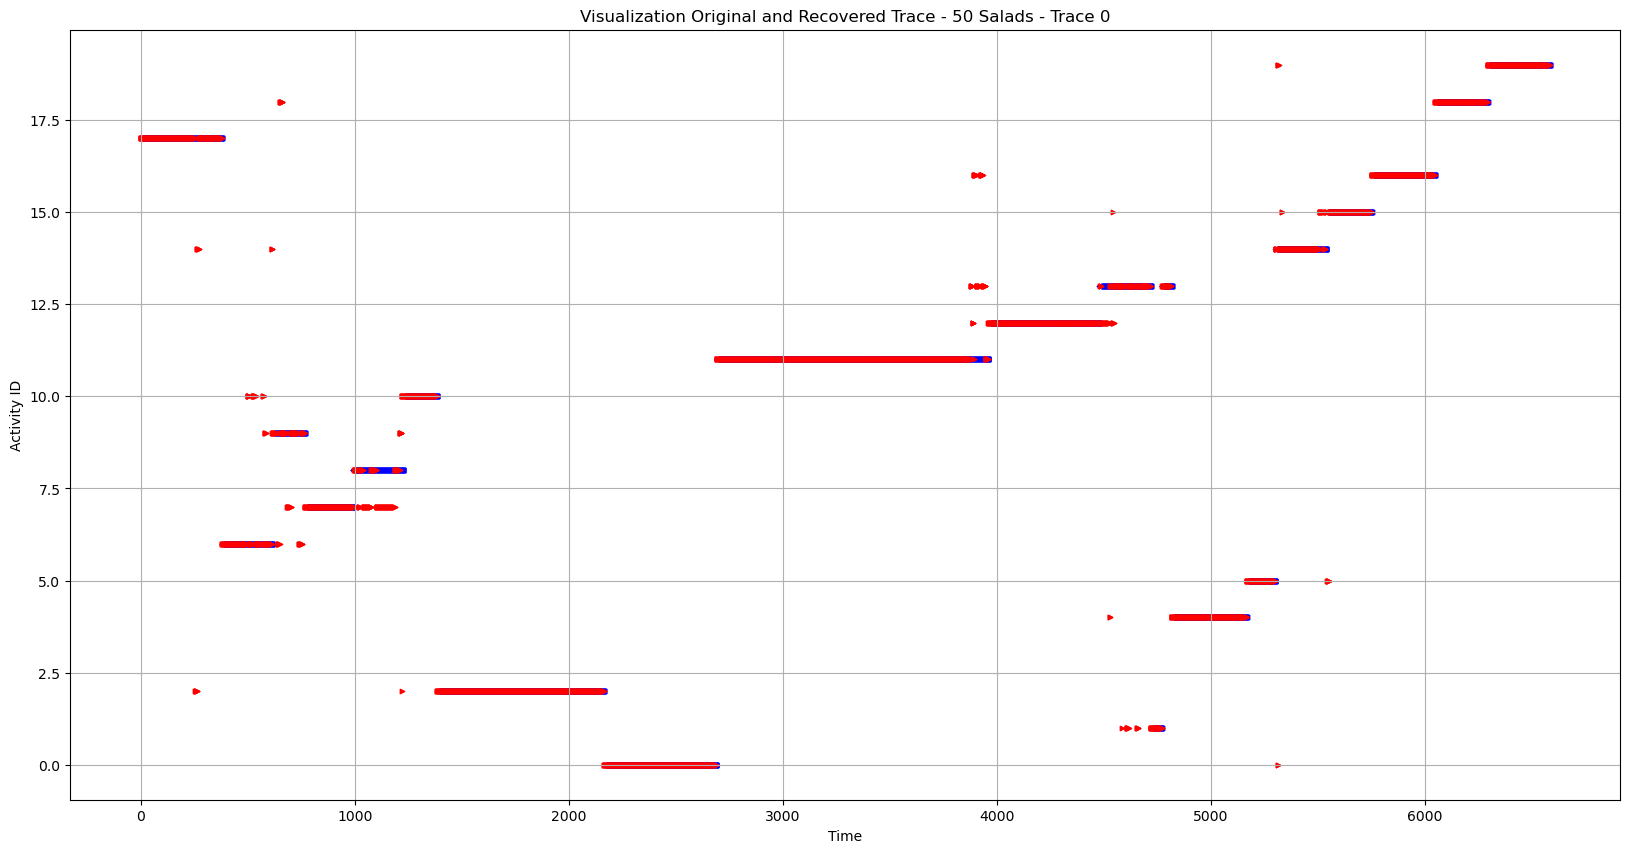

In [35]:
import matplotlib.pyplot as plt

i = random.choice(range(len(salads_original)))
original, recovered, amax = salads_original[i].to('cpu'), salads_recovered[i].to('cpu'), salads_argmax[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - 50 Salads - Trace {i}')
plt.grid(True)

plt.show()

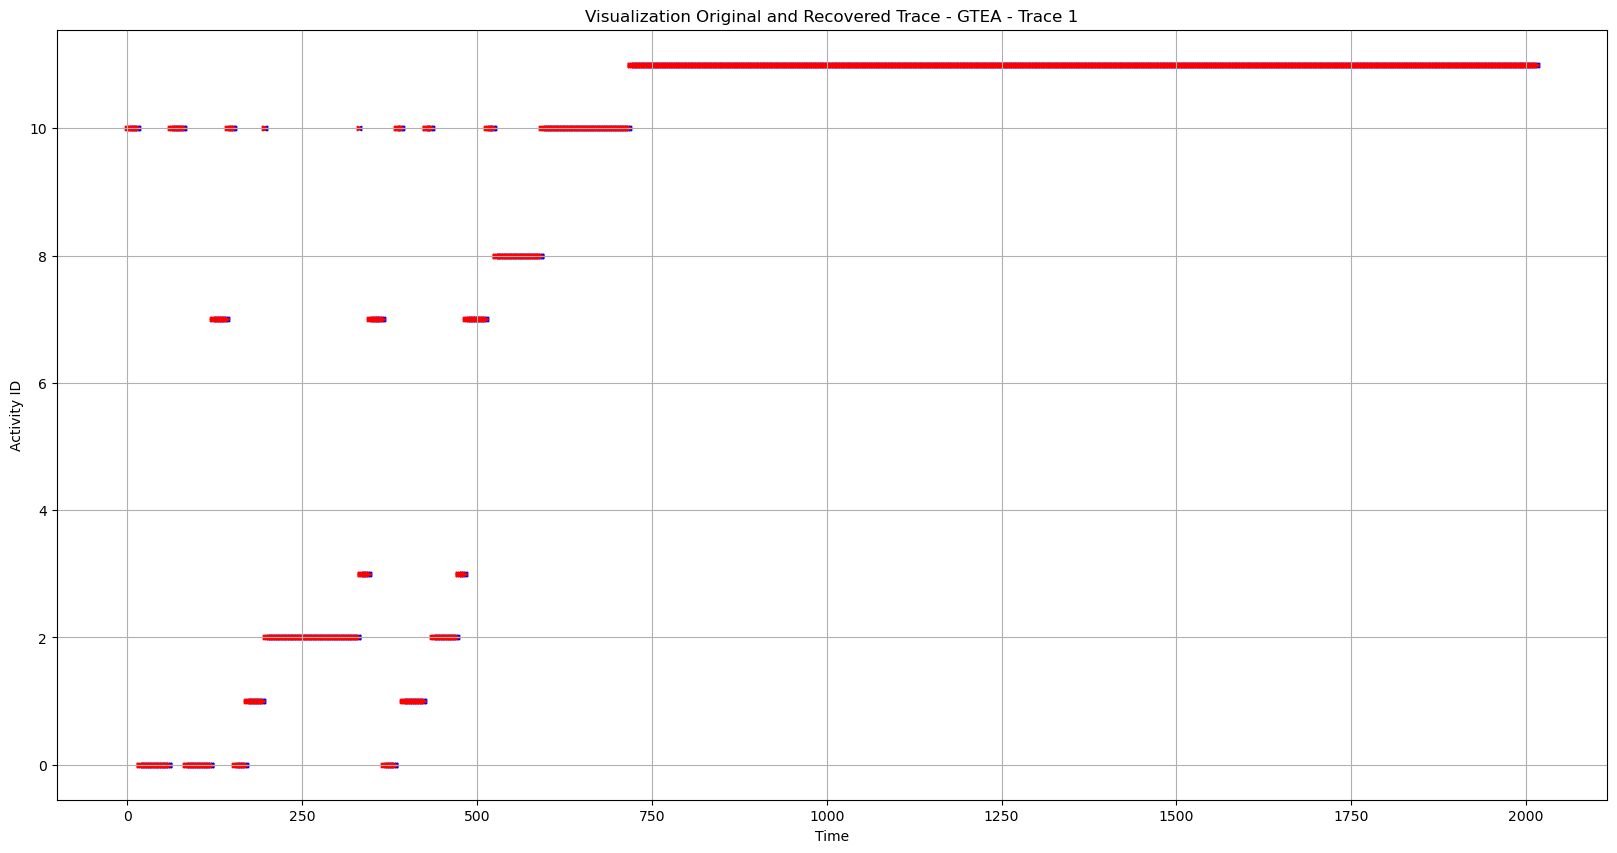

In [32]:
import matplotlib.pyplot as plt

i = random.choice(range(len(gtea_original)))
original, recovered = gtea_original[i].to('cpu'), gtea_recovered[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - GTEA - Trace {i}')
plt.grid(True)

plt.show()

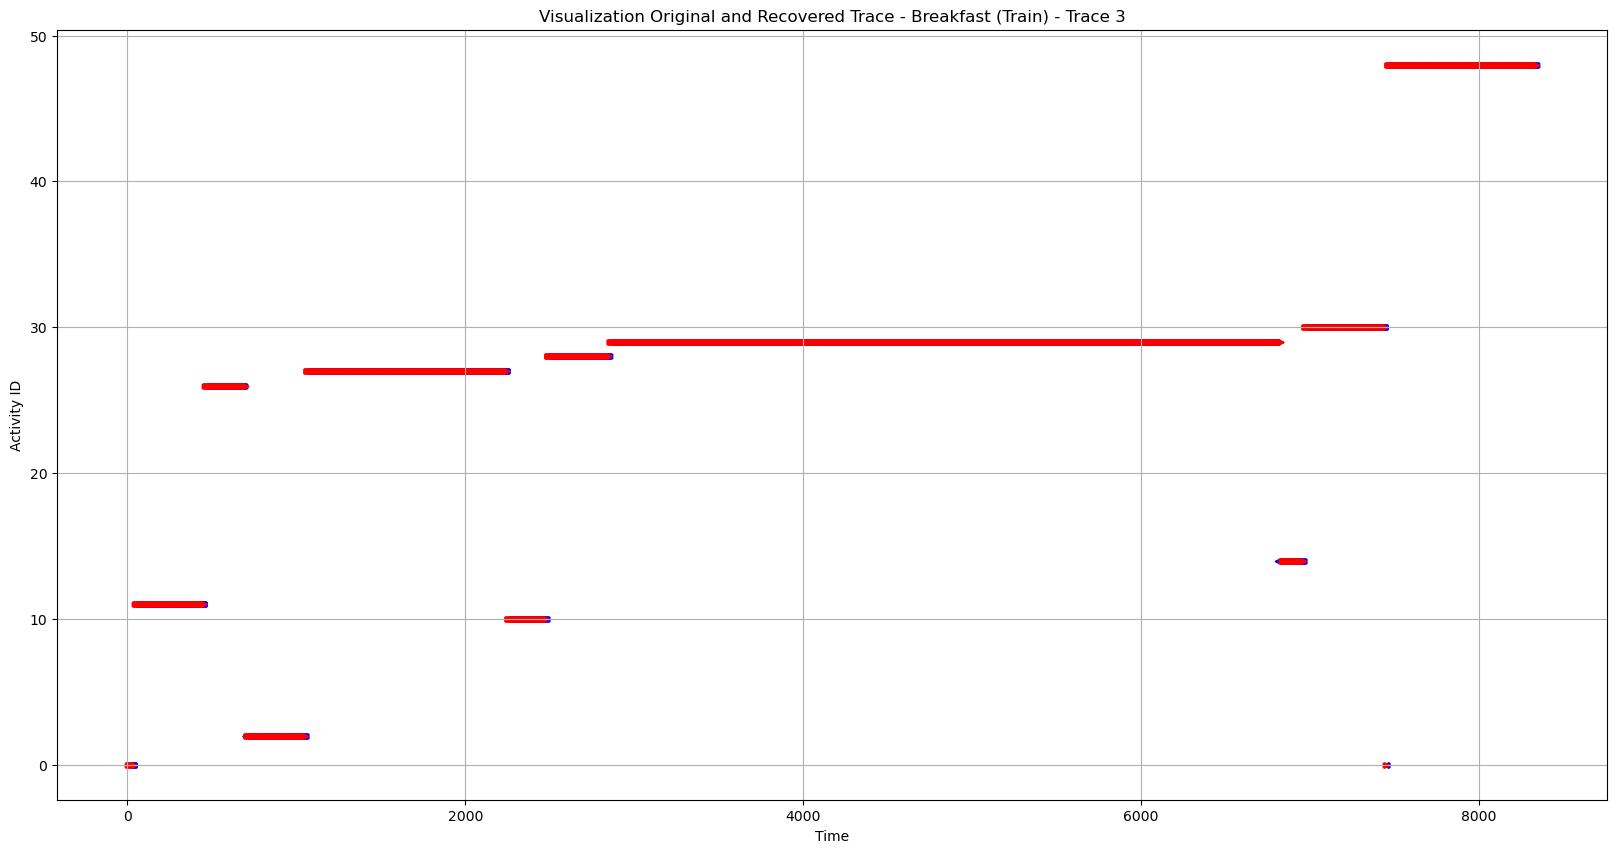

In [33]:
plt.show()
import matplotlib.pyplot as plt

i = random.choice(range(len(breakfast_original)))
original, recovered = breakfast_original[i].to('cpu'), breakfast_recovered[i].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(original)), original, marker='<', c='b', s=10)
plt.scatter(range(len(recovered)), recovered, marker='>', c='r', s=10)

plt.xlabel('Time')
plt.ylabel('Activity ID')
plt.title(f'Visualization Original and Recovered Trace - Breakfast (Train) - Trace {i}')
plt.grid(True)

plt.show()